La tercera etapa en un proyecto típico de NLP sería evaluar el modelo. Ya hemos discutido la evaluación en la etapa de pruebas, donde aplicamos el modelo a un conjunto de datos de prueba independiente y medimos su rendimiento.

En esta etapa, querríamos recoger métricas que nos ayuden a entender cuán bien está funcionando nuestro modelo. Estas métricas varían dependiendo de la tarea, pero en un problema de clasificación de texto como este, podríamos considerar lo siguiente:

Precisión: Esta es la proporción de predicciones correctas entre todas las predicciones hechas. Esto nos da una idea general de cómo está funcionando el modelo.

Recall: Esta es la proporción de verdaderos positivos que se identificaron correctamente. Es especialmente importante en situaciones donde los falsos negativos son problemáticos.

F1 Score: Este es un promedio ponderado de la precisión y la recall. Es útil si necesitas un equilibrio entre precisión y recall y hay una distribución desigual de las clases.

Confusion Matrix: Esta es una tabla que te permite visualizar el rendimiento de tu algoritmo. Muestra los verdaderos positivos, los verdaderos negativos, los falsos positivos y los falsos negativos.

Podemos utilizar la biblioteca sklearn para obtener estas métricas. Aquí te muestro un ejemplo de cómo podrías hacerlo:

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
from transformers import TFCamembertForSequenceClassification, CamembertTokenizer
import numpy as np
import tensorflow as tf
import pandas as pd

# Asegúrate de tener la siguiente línea si no has definido el tokenizer anteriormente en tu script
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

# Carga los datos de validación
val_df = pd.read_csv('../../dataset/processed_data.csv')

# Convierte 'label' a int y reemplaza los valores NaN en 'phrase' con un string vacío
val_df['label'] = val_df['label'].astype(int)
val_df['phrase'] = val_df['phrase'].fillna('')

# Cargar el modelo guardado
model = TFCamembertForSequenceClassification.from_pretrained('path_to_save_model', num_labels=5)

# Crear un TF Dataset para la validación
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['phrase'].values, val_df['label'].values))

def map_example_to_dict(input_ids, attention_masks, label):
    return {"input_ids": input_ids, "attention_mask": attention_masks}, label

def encode_examples(s, l):
    input_ids_list = []
    attention_mask_list = []
    label_list = []

    for phrase, label in zip(s, l):
        bert_input = tokenizer(phrase, truncation=True, padding='max_length', max_length=64)

        input_ids_list.append(bert_input['input_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, label_list)).map(map_example_to_dict)

# Convertir el DataFrame de validación en un TF Dataset
val_dataset_encoded = encode_examples(val_df['phrase'].values, val_df['label'].values)

# Preparar el dataset para la evaluación
val_dataset_encoded = val_dataset_encoded.batch(16).prefetch(tf.data.experimental.AUTOTUNE)

# Evaluar el modelo en el conjunto de validación
val_preds = model.predict(val_dataset_encoded)

# Obtener las etiquetas predichas
val_preds_labels = np.argmax(val_preds[0], axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(val_df['label'].values, val_preds_labels)
print(cm)

# Calcular las métricas de clasificación
report = classification_report(val_df['label'].values, val_preds_labels)
print(report)


All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at path_to_save_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


259/259 [==============================] - 235s 901ms/step
[[664  46  25   3  64]
 [ 37 420   3   7 295]
 [ 68   8 749   1  19]
 [  3   5   3 781  13]
 [ 17  51   7  10 840]]
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       802
           1       0.79      0.55      0.65       762
           2       0.95      0.89      0.92       845
           3       0.97      0.97      0.97       805
           4       0.68      0.91      0.78       925

    accuracy                           0.83      4139
   macro avg       0.85      0.83      0.83      4139
weighted avg       0.85      0.83      0.83      4139



In [ ]:
print(val_df.head())


In [ ]:
for i in val_dataset.take(5):
    print(i)


Verificar el balance de las clases

In [ ]:
print(val_df['sentiment'].value_counts())


Comprueba la distribución de las clases en el conjunto de validación

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(val_df, test_size=0.2, stratify=val_df['label'], random_state=42)


In [ ]:
print(val_df['sentiment'].value_counts())


In [1]:
from transformers import TFCamembertForSequenceClassification, CamembertTokenizer

# Cargar el modelo y el tokenizador
model = TFCamembertForSequenceClassification.from_pretrained(model_dir)
tokenizer = CamembertTokenizer.from_pretrained(model_dir)


C:\Users\kn-dr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'model_dir' is not defined

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
All model checkpoint layers were used when initializing TFCamembertForSequenceClassification.

All the layers of TFCamembertForSequenceClassification were initialized from the model checkpoint at d:\Python Code\Project\analyzer\models\path_to_save_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForSequenceClassification for predictions without further training.


52/52 [==============================] - 49s 890ms/step - loss: 0.5008 - accuracy: 0.8502
Test Loss: 0.5008377432823181
Test Accuracy: 0.8502415418624878
52/52 [==============================] - 54s 956ms/step
              precision    recall  f1-score   support

 frustration       0.89      0.73      0.80       177
   tristesse       0.77      0.84      0.80       158
      colere       0.85      0.99      0.91       168
        joie       0.95      0.94      0.95       140
      neutre       0.82      0.77      0.80       185

    accuracy                           0.85       828
   macro avg       0.86      0.86      0.85       828
weighted avg       0.85      0.85      0.85       828



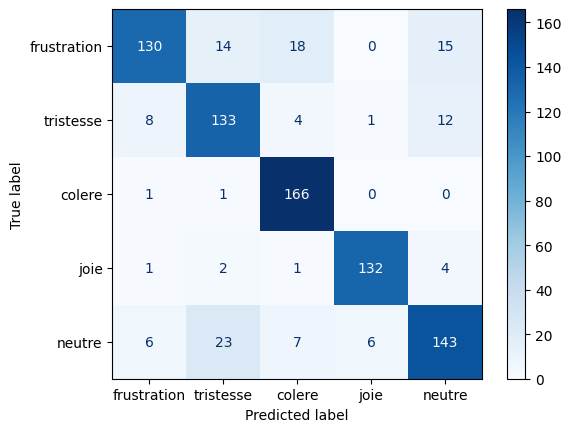

In [5]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from transformers import CamembertTokenizer, TFCamembertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Cargar los datos procesados
df = pd.read_csv('../../dataset/processed_data.csv')

# Dividir los datos en conjuntos de entrenamiento y prueba
_, X_test, _, y_test = train_test_split(df['phrase'].fillna(''), df['label'], test_size=0.2, random_state=42)

# Preparar los datos para el modelo CamemBERT
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

def encode_reviews(text, label):
    encoded_dict = tokenizer.encode_plus(
        text.numpy().decode('utf-8'),
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf',
    )

    input_id = encoded_dict['input_ids'][0]
    attention_mask = encoded_dict['attention_mask'][0]

    return input_id, attention_mask, label

def tf_encode(text_tensor, label_tensor):
    input_id, attention_mask, label = tf.py_function(encode_reviews, [text_tensor, label_tensor], [tf.int32, tf.int32, tf.int64])
    input_id.set_shape([64])
    attention_mask.set_shape([64])
    label.set_shape([])
    return {'input_ids': input_id, 'attention_mask': attention_mask}, label

text_test_tensor = tf.convert_to_tensor(X_test.values, dtype=tf.string)
label_test_tensor = tf.convert_to_tensor(y_test.values, dtype=tf.int64)

test_dataset = tf.data.Dataset.from_tensor_slices((text_test_tensor, label_test_tensor)).map(tf_encode).batch(16)

# Cargar el modelo entrenado
model_base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'models'))
model_dir = os.path.join(model_base_dir, 'path_to_save_model')
model = TFCamembertForSequenceClassification.from_pretrained(model_dir)

# Compilar el modelo antes de evaluar
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Evaluar el modelo
results = model.evaluate(test_dataset)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

# Obtener las predicciones
y_pred = model.predict(test_dataset)
y_pred_labels = tf.argmax(y_pred.logits, axis=1).numpy()

# Imprimir el informe de clasificación
print(classification_report(y_test, y_pred_labels, target_names=['frustration', 'tristesse', 'colere', 'joie', 'neutre']))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['frustration', 'tristesse', 'colere', 'joie', 'neutre'])
disp.plot(cmap=plt.cm.Blues)
plt.show()
